In [292]:
import os
import pandas as pd
import numpy as np
import string as s
import seaborn as sns
import math
# import tables
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style, colors
from itertools import groupby
import matplotlib.patches as patches
from matplotlib import gridspec
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.ndimage.interpolation import shift
# matplotlib.style.use('ggplot')
# %matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
# matplotlib.rcParams['figure.facecolor'] = 'white'
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll
matplotlib.style.use('ggplot')
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


https://stats.stackexchange.com/questions/117012/how-do-i-calculate-bic-score-for-hmm/126343#126343
model selection for chromHMM:

1) redundancy/complexity/interpretability;
minimal redundant states. we could reasonably interpret each chomatin state in a biologically meaningful way. each combinatorial marks may represent a distinct functional consequences. the number of states reflects genuine compelxity in biological chromatin states. balance model complexity vs interpretability.
2) Epigenome Roadmap Atlas Project can be used as reference. 5 marks, 127 epigenomes, they picked 15 states model.
3) interpretability is a moving standard as reseach progress. we only see what we know. compare states to other gold-standard functional annotations, like TSS, gene bodies, and enhancers etc.


In [47]:
wkdir = '/projects/da_workspace/software/ChromHMM/Cervical/'

In [6]:
f1 = '/projects/da_workspace/software/ChromHMM/Cervical/OUTPUT_16/states_file.txt'
df1 = pd.read_csv(f1, sep='\t', header=None)
df1.head(2)

,0
0,/projects/da_workspace/software/ChromHMM/Cervi...
1,/projects/da_workspace/software/ChromHMM/Cervi...


In [204]:
df = pd.DataFrame({'ab':[1,2,1], 'b':[4,5,6], 'a':[44,55,66]}).set_index('ab')
df

,a,b
ab,,
1,44,4
2,55,5
1,66,6


In [207]:
df.groupby(df.index)?

SyntaxError: invalid syntax (<ipython-input-207-8ef396ae85f2>, line 1)

In [36]:
dfm = pd.DataFrame()
for idx, f in df1.iterrows():
    patient = f[0].split('/')[7].split('_')[0]
#     print(idx, f, patient)
    dftmp = pd.read_csv(f[0], sep='\t', header=None)
    dftmp = dftmp[[0,1,3,7]].set_index([0,1,3])
#     drop entries with duplicate index
    dftmp = dftmp.groupby(dftmp.index).first()
    dftmp.columns = [patient]
#     print(dftmp.head(2))
    if dfm.empty:
        dfm = dftmp
    else:
        dfm = pd.merge(dfm, dftmp, left_index=True, right_index=True, how='inner')
    print(dfm.shape)    
#     break

0 0    /projects/da_workspace/software/ChromHMM/Cervi...
Name: 0, dtype: object HTMCP-03-06-02001
(20046, 1)
1 0    /projects/da_workspace/software/ChromHMM/Cervi...
Name: 1, dtype: object HTMCP-03-06-02006
(20046, 2)
2 0    /projects/da_workspace/software/ChromHMM/Cervi...
Name: 2, dtype: object HTMCP-03-06-02007
(20046, 3)
3 0    /projects/da_workspace/software/ChromHMM/Cervi...
Name: 3, dtype: object HTMCP-03-06-02012
(20046, 4)
4 0    /projects/da_workspace/software/ChromHMM/Cervi...
Name: 4, dtype: object HTMCP-03-06-02020
(20046, 5)
5 0    /projects/da_workspace/software/ChromHMM/Cervi...
Name: 5, dtype: object HTMCP-03-06-02026
(20046, 6)
6 0    /projects/da_workspace/software/ChromHMM/Cervi...
Name: 6, dtype: object HTMCP-03-06-02040
(20046, 7)
7 0    /projects/da_workspace/software/ChromHMM/Cervi...
Name: 7, dtype: object HTMCP-03-06-02042
(20046, 8)
8 0    /projects/da_workspace/software/ChromHMM/Cervi...
Name: 8, dtype: object HTMCP-03-06-02054
(20046, 9)
9 0    /projects/da

In [51]:
dfn = dfm.apply(lambda x: x.str.replace('E', ''))

In [203]:
dfn.shape

(20046, 35)

In [54]:
# dfn.reset_index().head(2)

,index,HTMCP-03-06-02001,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02012,HTMCP-03-06-02020,HTMCP-03-06-02026,HTMCP-03-06-02040,HTMCP-03-06-02042,HTMCP-03-06-02054,...,HTMCP-03-06-02203,HTMCP-03-06-02205,HTMCP-03-06-02210,HTMCP-03-06-02214,HTMCP-03-06-02260,HTMCP-03-06-02266,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02330,HTMCP-03-06-02332
0,"(chr1, 36080, ENSG00000237613)",11,12,12,12,12,12,12,12,11,...,12,13,12,12,12,12,12,12,12,11
1,"(chr1, 69091, ENSG00000186092)",12,12,12,12,12,12,12,12,12,...,13,12,11,12,12,11,12,12,12,12


In [53]:
of = '/projects/da_workspace/software/ChromHMM/Cervical/OUTPUT_16/states_matrix.txt'
dfn.to_csv(of)

In [200]:
dfo = dfn.reset_index(drop=True).astype(int)
dfo['occ'] = dfo.T.apply(lambda x: x.nunique())
dfo = dfo[(dfo.occ > 2)].drop('occ', axis=1)

In [173]:
dfo.shape

(10826, 35)

In [ ]:
# dfo.to_csv('/projects/da_workspace/software/ChromHMM/Cervical/OUTPUT_16/')

In [175]:
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/'
ct = '{}category_track.txt'.format(wkdir)
ctdf = pd.read_csv(ct)
ctdf.head(2)

,patient,HIV_status,Putative_histology,HPV_status,Remodeller,Reader,Writer,Eraser,SWI/SNF remodeling complex,SWI/SNF family,...,ISWI chromatin remdelling,HAT complexes,NuRD complex,compass complex,HDAC complex,GNAT family HAT complexes,MYST family HAT complexes,RNF20/40 complex,SWI/SNF remodeling complex,TFIID basal transcription factor complex or PCAF histone acetylase complex
0,HTMCP-03-06-02007,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,Positive,Positive,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive
1,HTMCP-03-06-02026,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Positive,Positive,Positive,Positive,Positive,Positive,Negative,Negative,Positive


In [176]:
def map_features_to_colors(df_track, map_dict1, clrs):
#     clrs = ["purple", "#E69F00","#009E73","#56B4E9"]#,"#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
#     map_dict1 =  {'Adeno': 0.15,'Squamous': 0.25, 'Negative': 0.35, 'Positive': 0.45}
    map_dict2 = {}
    for n, k in enumerate(map_dict1.keys()):
        map_dict2[k] = clrs[n]
    assert list(map_dict2.values()) == clrs
    ndf_track = df_track.apply(lambda x: x.map(map_dict1)).fillna(0).T
#     legends = sorted(map_dict1, key=map_dict1.get, reverse=False)
    return (ndf_track, map_dict2)

In [177]:
cat_track = ctdf.set_index('patient')
clrs = ["purple", "#E69F00","#009E73","#56B4E9"]#,"#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
map_dict1 =  {'Adeno': 0.15,'Squamous': 0.25, 'Negative': 0.35, 'Positive': 0.45}
ncategory_track, map_dict2 = map_features_to_colors(cat_track, map_dict1, clrs)


category track shape: rows=27, cols=35


/projects/da_workspace/software/anaconda/lib/python3.6/site-packages/matplotlib/colorbar.py:218: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


[]

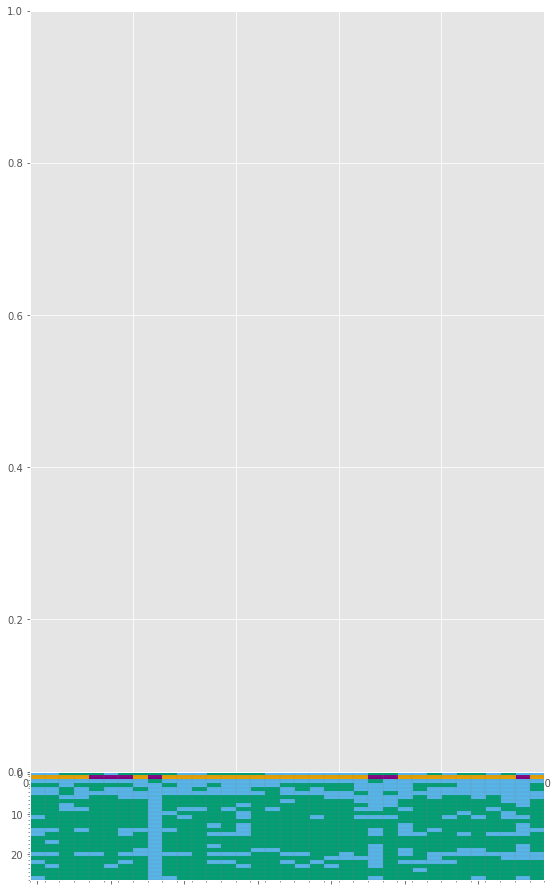

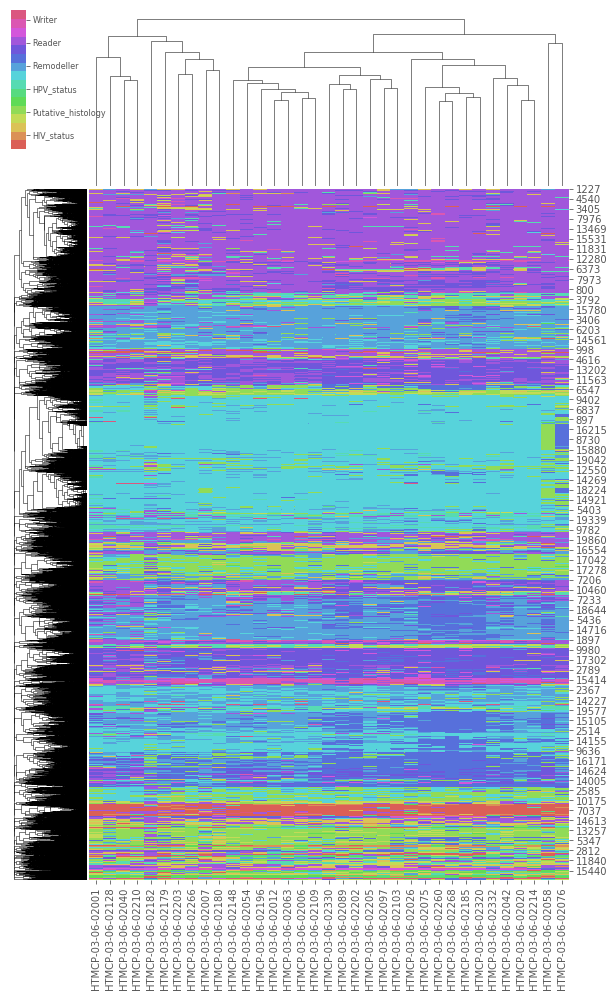

In [199]:
fig = plt.figure(figsize=(10, 16), facecolor='white')
gs = gridspec.GridSpec(1, 2, width_ratios=[17,1], 
                       wspace=0.05, # horizontal space
                       hspace=0.0  # vertical space
                      )


# # left panel 3x1 for n_track, c_trak, and dendrogram
gs01 = gridspec.GridSpecFromSubplotSpec(2, 1,  height_ratios=[14,2], subplot_spec=gs[0],  hspace=0.0)
bounds = np.arange(0.05, len(map_dict1)/10.0 + 0.1 , 0.1).tolist()
assert len(bounds) == len(map_dict1) + 1    
cmap = colors.ListedColormap(clrs)
norm = colors.BoundaryNorm(bounds, cmap.N)
nrow = len(ncategory_track.index)
ncol = len(ncategory_track.columns)
print('category track shape: rows={0}, cols={1}'.format(nrow, ncol))

# add dendrogram
ax1_1 = fig.add_subplot(gs01[0])
ax1_1.set_title("")
# fig = plt.figure(facecolor='white', figsize=(6,20))
ax = sns.clustermap(dfo, method='complete', metric='hamming', figsize=(10,16), cmap=sns.color_palette("hls", 16))

# plot category track
ax1_2 = fig.add_subplot(gs01[1])
ax1_2.set_title("")

c_track = ncategory_track[sample_order]
# print(c_track.head(2))

# fig =  plt.figure()
# ax1_2 = fig.add_subplot(111, facecolor='white')
#     ax1_2.set_title("")
#     print(c_track)
img = ax1_2.imshow(c_track.values, interpolation='none', origin='upper', aspect='auto',
                    cmap=cmap, norm=norm)
_ = plt.yticks(np.arange(0, nrow, 1), c_track.index, fontsize=8)
_ = plt.xticks(np.arange(0, ncol, 1), c_track.columns, fontsize=8, rotation=90)

_ = ax1_2.set_yticks(np.arange(-.5, nrow, 1), minor=True);
_ = ax1_2.set_xticks(np.arange(-.5, ncol, 1), minor=True);

# Gridlines based on minor ticks
_ = ax1_2.grid(b=True, which='minor', color='gray', linestyle='--', linewidth=0.3)
# hide major tick grid
_ = ax1_2.grid(b=True, which='major', color='r', linestyle='-', linewidth=0)

ax1_2.spines['right'].set_visible(True)
ax1_2.spines['top'].set_visible(True)
ax1_2.set_xticklabels('')
#     print(c_track.columns)

In [202]:
dfo.shape

(10826, 35)

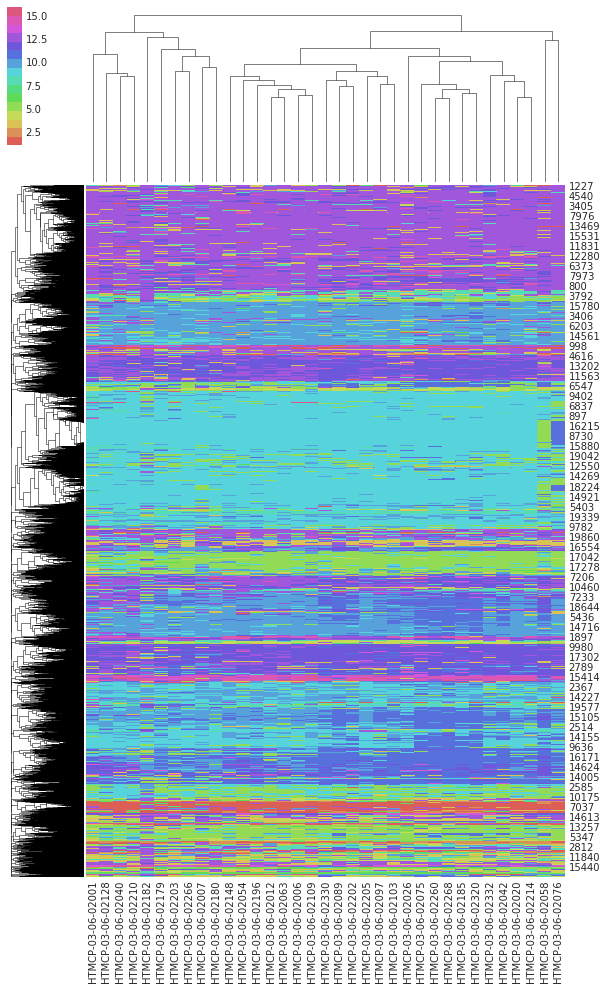

In [201]:
with plt.style.context("seaborn-white"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    fig = plt.figure(facecolor='white', figsize=(6,20))
    ax = sns.clustermap(dfo, method='complete', metric='hamming', figsize=(10,16), cmap=sns.color_palette("hls", 16))
    ax.savefig('/projects/da_workspace/software/ChromHMM/Cervical/OUTPUT_16/states_clustering.png', bbox_inches='tight', dpi=300)

In [188]:
sample_order = [(dfo.columns.tolist())[i] for i in ax.dendrogram_col.reordered_ind]

In [165]:
ax.dendrogram_col.reordered_ind

[21,
 0,
 17,
 6,
 27,
 19,
 2,
 25,
 20,
 30,
 8,
 18,
 23,
 3,
 10,
 1,
 16,
 34,
 7,
 4,
 28,
 33,
 13,
 24,
 26,
 14,
 15,
 5,
 11,
 31,
 32,
 22,
 29,
 9,
 12]

In [3]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/chipseq_meta.txt'
df1 = pd.read_csv(of, sep='\t')
df1.head(2)

,H3K4me1 library ID,H3K4me3 library ID,H3K9me3 library ID,H3K27me3 library ID,H3K36me3 library ID,H3K27ac library ID,input DNA control library ID,H3K4me1 total reads,H3K4me3 total reads,H3K9me3 total reads,H3K27me3 total reads,H3K36me3 total reads,H3K27ac total reads,input DNA control total reads,patient,HIV_status,Putative_histology,strelka_mutations,HPV_status
0,A84624,A84625,A84626,A84627,A84628,A84629,A84630,78611726,60179836,76557498,90312752.0,106610232.0,80676254.0,86539886.0,HTMCP-03-06-02007,Negative,Adeno,2958282,Negative
1,A84645,A84646,A84647,A84648,A84649,A84650,A84651,85566812,74487212,93042922,89559600.0,87905340.0,84986034.0,88575282.0,HTMCP-03-06-02026,Negative,Adeno,1252217,Negative


In [4]:
patients = df1.patient.tolist()
assert len(patients) == 35

In [5]:
chrs = ['{}'.format(i) for i in range(1,22)] +["X"]
# chrs

In [24]:
def signal_intervals(chrs, patients):
    dfm = pd.DataFrame()
    for chr in chrs:
        dfchr = pd.DataFrame()
        print('processing chromosome: {}'.format(chr))
        for pat in patients:
            bf =  '{0}{1}_{2}_binary.txt.chr_suffix'.format(wkdir, pat, chr)
    #         print(bf)
            dfb = pd.read_csv(bf, sep='\t', skiprows=1)
            dfb1 = dfb[(dfb.T != 0).any()]
            # add in genomic coordinates
            dfb3 = dfb1.reset_index()
            dfb3['chr'] = chr
            dfb3['ix1'] = dfb3['index']*200
            dfb3['ix2'] = dfb3['index']*200 + 200
            dfb3 = dfb3.drop('index', axis=1)
#             dfb3 = dfb3[['chr', 'ix1', 'ix2']]
            if dfchr.empty:
                dfchr = dfb3
            else:
                dfchr = pd.concat([dfchr, dfb3]).drop_duplicates()
        if dfm.empty:
            dfm = dfchr
        else:
            dfm = pd.concat([dfm, dfchr])
    return dfm

In [14]:
signal_intervals = signal_intervals(chrs, patients)

processing chromosome: 1
processing chromosome: 2
processing chromosome: 3
processing chromosome: 4
processing chromosome: 5
processing chromosome: 6
processing chromosome: 7
processing chromosome: 8
processing chromosome: 9
processing chromosome: 10
processing chromosome: 11
processing chromosome: 12
processing chromosome: 13
processing chromosome: 14
processing chromosome: 15
processing chromosome: 16
processing chromosome: 17
processing chromosome: 18
processing chromosome: 19
processing chromosome: 20
processing chromosome: 21
processing chromosome: X


In [11]:
signal_intervals[['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3',
       'H3K9me3']].sum()

H3K27ac     1001192
H3K27me3     846434
H3K36me3    1045069
H3K4me1     1437008
H3K4me3      666833
H3K9me3      565176
dtype: int64

In [12]:
signal_intervals.head()

,H3K27ac,H3K27me3,H3K36me3,H3K4me1,H3K4me3,H3K9me3,chr,ix1,ix2
0,1,1,1,1,1,1,1,10000,10200
1,1,0,0,0,0,1,1,10200,10400
2,0,0,0,1,0,0,1,11600,11800
3,0,0,1,1,0,0,1,11800,12000
4,0,0,1,1,0,0,1,12000,12200


In [21]:
signal_intervals.shape

(34283697, 9)

In [23]:
signal_intervals = signal_intervals[['chr', 'ix1', 'ix2']].drop_duplicates()

In [15]:
of = '{0}signal_intervals.txt'.format(wkdir)
signal_intervals.to_csv(of)

In [ ]:
signal_intervals.sum()

In [16]:
marks = ["H3K4me1",
"H3K4me3",
"H3K9me3",
"H3K27me3",
"H3K36me3",
"H3K27ac"
]

In [214]:
# for mark in marks[:1]:
#     print(dfm[dfm[mark] != 0].shape)
#     dfmark = dfm[dfm[mark] != 0][['chr', 'ix1', 'ix2', mark]].drop_duplicates().set_index(['chr', 'ix1', 'ix2'])
#     print(dfmark.shape)

In [17]:
def concat_sigs(chrs, patient):
    dfpat = pd.DataFrame()    
    for chr in chrs:
        print('processing chromosome: {}'.format(chr))
        bf =  '{0}{1}_{2}_binary.txt.chr_suffix'.format(wkdir, patient, chr)
        dfb = pd.read_csv(bf, sep='\t', skiprows=1).reset_index()
        dfb['chr'] = chr
        dfb['ix1'] = dfb['index']*200
        dfb['ix2'] = dfb['index']*200 + 200
        dfb = dfb.drop('index', axis=1)
        if dfpat.empty:
            dfpat = dfb
        else:
            dfpat = pd.concat([dfpat, dfb]).drop_duplicates()
        of = '{0}{1}_signals_concated.txt'
    return dfpat

In [18]:
sig_dicts = {}
for pat in patients:
    print(pat)
    sig_dicts[pat] = concat_sigs(chrs, pat)

HTMCP-03-06-02007
processing chromosome: 1
processing chromosome: 2
processing chromosome: 3
processing chromosome: 4
processing chromosome: 5
processing chromosome: 6
processing chromosome: 7
processing chromosome: 8
processing chromosome: 9
processing chromosome: 10
processing chromosome: 11
processing chromosome: 12
processing chromosome: 13
processing chromosome: 14
processing chromosome: 15
processing chromosome: 16
processing chromosome: 17
processing chromosome: 18
processing chromosome: 19
processing chromosome: 20
processing chromosome: 21
processing chromosome: X
HTMCP-03-06-02026
processing chromosome: 1
processing chromosome: 2
processing chromosome: 3
processing chromosome: 4
processing chromosome: 5
processing chromosome: 6
processing chromosome: 7
processing chromosome: 8
processing chromosome: 9
processing chromosome: 10
processing chromosome: 11
processing chromosome: 12
processing chromosome: 13
processing chromosome: 14
processing chromosome: 15
processing chromosome

processing chromosome: 4
processing chromosome: 5
processing chromosome: 6
processing chromosome: 7
processing chromosome: 8
processing chromosome: 9
processing chromosome: 10
processing chromosome: 11
processing chromosome: 12
processing chromosome: 13
processing chromosome: 14
processing chromosome: 15
processing chromosome: 16
processing chromosome: 17
processing chromosome: 18
processing chromosome: 19
processing chromosome: 20
processing chromosome: 21
processing chromosome: X
HTMCP-03-06-02006
processing chromosome: 1
processing chromosome: 2
processing chromosome: 3
processing chromosome: 4
processing chromosome: 5
processing chromosome: 6
processing chromosome: 7
processing chromosome: 8
processing chromosome: 9
processing chromosome: 10
processing chromosome: 11
processing chromosome: 12
processing chromosome: 13
processing chromosome: 14
processing chromosome: 15
processing chromosome: 16
processing chromosome: 17
processing chromosome: 18
processing chromosome: 19
processing

processing chromosome: 7
processing chromosome: 8
processing chromosome: 9
processing chromosome: 10
processing chromosome: 11
processing chromosome: 12
processing chromosome: 13
processing chromosome: 14
processing chromosome: 15
processing chromosome: 16
processing chromosome: 17
processing chromosome: 18
processing chromosome: 19
processing chromosome: 20
processing chromosome: 21
processing chromosome: X
HTMCP-03-06-02103
processing chromosome: 1
processing chromosome: 2
processing chromosome: 3
processing chromosome: 4
processing chromosome: 5
processing chromosome: 6
processing chromosome: 7
processing chromosome: 8
processing chromosome: 9
processing chromosome: 10
processing chromosome: 11
processing chromosome: 12
processing chromosome: 13
processing chromosome: 14
processing chromosome: 15
processing chromosome: 16
processing chromosome: 17
processing chromosome: 18
processing chromosome: 19
processing chromosome: 20
processing chromosome: 21
processing chromosome: X
HTMCP-03

In [19]:
for mark in marks:
    df_merged = pd.DataFrame()
    dfmark = signal_intervals[signal_intervals[mark] != 0][['chr', 'ix1', 'ix2', mark]].drop_duplicates().set_index(['chr', 'ix1', 'ix2'])
    print('mark:{}'.format(mark))
    for pat in patients:
        print(pat)
        dfpat = sig_dicts[pat]
        dfpat_mark = dfpat[['chr', 'ix1', 'ix2', mark]].set_index(['chr', 'ix1', 'ix2'])
        dfpat_mark.columns = [pat]
        if df_merged.empty:
            df_merged = dfpat_mark.reindex(dfmark.index)
        else:
            df_merged = pd.merge(df_merged, dfpat_mark, left_index=True, right_index=True, how='left')
    #             df_merged = df_merged.drop('{}_x'.format(mark), axis=1)
    print(df_merged.head(2))
    of = '{0}{1}_matrix.txt'.format(wkdir, mark)
    df_merged.to_csv(of)



mark:H3K4me1
HTMCP-03-06-02007
HTMCP-03-06-02026
HTMCP-03-06-02063
HTMCP-03-06-02214
HTMCP-03-06-02042
HTMCP-03-06-02332
HTMCP-03-06-02185
HTMCP-03-06-02012
HTMCP-03-06-02196
HTMCP-03-06-02203
HTMCP-03-06-02180
HTMCP-03-06-02266
HTMCP-03-06-02210
HTMCP-03-06-02075
HTMCP-03-06-02040
HTMCP-03-06-02006
HTMCP-03-06-02182
HTMCP-03-06-02058
HTMCP-03-06-02260
HTMCP-03-06-02001
HTMCP-03-06-02054
HTMCP-03-06-02320
HTMCP-03-06-02020
HTMCP-03-06-02330
HTMCP-03-06-02128
HTMCP-03-06-02097
HTMCP-03-06-02268
HTMCP-03-06-02202
HTMCP-03-06-02148
HTMCP-03-06-02103
HTMCP-03-06-02089
HTMCP-03-06-02205
HTMCP-03-06-02179
HTMCP-03-06-02109
HTMCP-03-06-02076
                 HTMCP-03-06-02007  HTMCP-03-06-02026  HTMCP-03-06-02063  \
chr ix1   ix2                                                              
1   10000 10200                  1                  0                  0   
    11600 11800                  1                  1                  1   

                 HTMCP-03-06-02214  HTMCP-03-06-0204

mark:H3K27me3
HTMCP-03-06-02007
HTMCP-03-06-02026
HTMCP-03-06-02063
HTMCP-03-06-02214
HTMCP-03-06-02042
HTMCP-03-06-02332
HTMCP-03-06-02185
HTMCP-03-06-02012
HTMCP-03-06-02196
HTMCP-03-06-02203
HTMCP-03-06-02180
HTMCP-03-06-02266
HTMCP-03-06-02210
HTMCP-03-06-02075
HTMCP-03-06-02040
HTMCP-03-06-02006
HTMCP-03-06-02182
HTMCP-03-06-02058
HTMCP-03-06-02260
HTMCP-03-06-02001
HTMCP-03-06-02054
HTMCP-03-06-02320
HTMCP-03-06-02020
HTMCP-03-06-02330
HTMCP-03-06-02128
HTMCP-03-06-02097
HTMCP-03-06-02268
HTMCP-03-06-02202
HTMCP-03-06-02148
HTMCP-03-06-02103
HTMCP-03-06-02089
HTMCP-03-06-02205
HTMCP-03-06-02179
HTMCP-03-06-02109
HTMCP-03-06-02076
                 HTMCP-03-06-02007  HTMCP-03-06-02026  HTMCP-03-06-02063  \
chr ix1   ix2                                                              
1   10000 10200                  1                  0                  0   
    27600 27800                  1                  0                  0   

                 HTMCP-03-06-02214  HTMCP-03-06-020

# cluster all signals in each 200bp intervals

In [48]:
f1 = '{}H3K4me3_matrix.txt'.format(wkdir)
df1 = pd.read_csv(f1, index_col=['chr', 'ix1', 'ix2'])
df1.head(2)

/projects/da_workspace/software/miniconda/envs/dlpy3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/projects/da_workspace/software/miniconda/envs/dlpy3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


HTMCP-03-06-02007  HTMCP-03-06-02026  HTMCP-03-06-02063  \
chr ix1   ix2                                                              
1   10000 10200                  1                  1                  0   
    13400 13600                  1                  0                  0   

                 HTMCP-03-06-02214  HTMCP-03-06-02042  HTMCP-03-06-02332  \
chr ix1   ix2                                                              
1   10000 10200                  1                  1                  0   
    13400 13600                  0                  0                  1   

                 HTMCP-03-06-02185  HTMCP-03-06-02012  HTMCP-03-06-02196  \
chr ix1   ix2                                                              
1   10000 10200                  1                  1                  1   
    13400 13600                  0                  0                  1   

                 HTMCP-03-06-02203        ...          HTMCP-03-06-02097  \
chr ix1   ix2                             ...                              
1   10000 10200                  0        ...                          1   
    13400 13600                  1        ...                          0   

                 HTMCP-03-06-02268  HTMCP-03-06-02202  HTMCP-03-06-02148  \
chr ix1   ix2                                                              
1   10000 10200                  0                  1                  1   
    13400 13600                  1                  0                  1   

                 HTMCP-03-06-02103  HTMCP-03-06-02089  HTMCP-03-06-02205  \
chr ix1   ix2                                                              
1   10000 10200                  1                  1                  1   
    13400 13600                  1                  1                  0   

                 HTMCP-03-06-02179  HTMCP-03-06-02109  HTMCP-03-06-02076  
chr ix1   ix2                                                             
1   10000 10200                  1                  0                  1  
    13400 13600                  1                  0                  0  

[2 rows x 35 columns]

In [49]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/chipseq_meta.txt'
# df_meta.to_csv(of, sep='\t', index=False)
df_meta = pd.read_csv(of, sep='\t')
df_meta.head(2)

,H3K4me1 library ID,H3K4me3 library ID,H3K9me3 library ID,H3K27me3 library ID,H3K36me3 library ID,H3K27ac library ID,input DNA control library ID,H3K4me1 total reads,H3K4me3 total reads,H3K9me3 total reads,H3K27me3 total reads,H3K36me3 total reads,H3K27ac total reads,input DNA control total reads,patient,HIV_status,Putative_histology,strelka_mutations,HPV_status
0,A84624,A84625,A84626,A84627,A84628,A84629,A84630,78611726,60179836,76557498,90312752.0,106610232.0,80676254.0,86539886.0,HTMCP-03-06-02007,Negative,Adeno,2958282,Negative
1,A84645,A84646,A84647,A84648,A84649,A84650,A84651,85566812,74487212,93042922,89559600.0,87905340.0,84986034.0,88575282.0,HTMCP-03-06-02026,Negative,Adeno,1252217,Negative


In [50]:
# category_track = df_meta[['patient', 'HIV_status', 'Putative_histology', 'HPV_status']]
numeric_track = df_meta[['patient', 'strelka_mutations', ]]
numeric_track['log_strelka_mutations'] = np.log10(numeric_track['strelka_mutations'])
numeric_track = numeric_track.drop('strelka_mutations', axis=1)
numeric_track.head(2)

/projects/da_workspace/software/miniconda/envs/dlpy3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,patient,log_strelka_mutations
0,HTMCP-03-06-02007,6.47104
1,HTMCP-03-06-02026,6.09768


In [51]:
f2 = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/category_track.txt'
category_track = pd.read_csv(f2)
category_track.head(2)

,patient,HIV_status,Putative_histology,HPV_status,Remodeller,Reader,Writer,Eraser,SWI/SNF remodeling complex,SWI/SNF family,...,ISWI chromatin remdelling,HAT complexes,NuRD complex,compass complex,HDAC complex,GNAT family HAT complexes,MYST family HAT complexes,RNF20/40 complex,SWI/SNF remodeling complex,TFIID basal transcription factor complex or PCAF histone acetylase complex
0,HTMCP-03-06-02007,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,Positive,Positive,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive
1,HTMCP-03-06-02026,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Positive,Positive,Positive,Positive,Positive,Positive,Negative,Negative,Positive


In [52]:
def map_features_to_colors(df_track, map_dict1, clrs):
#     clrs = ["purple", "#E69F00","#009E73","#56B4E9"]#,"#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
#     map_dict1 =  {'Adeno': 0.15,'Squamous': 0.25, 'Negative': 0.35, 'Positive': 0.45}
    map_dict2 = {}
    for n, k in enumerate(map_dict1.keys()):
        map_dict2[k] = clrs[n]
    assert list(map_dict2.values()) == clrs
    ndf_track = df_track.apply(lambda x: x.map(map_dict1)).fillna(0).T
#     legends = sorted(map_dict1, key=map_dict1.get, reverse=False)
    return (ndf_track, map_dict2)

In [101]:
linkage?

In [116]:
pdist(np.array([[1, 1], [0, 0]]), 'hamming')

array([ 1.])

In [117]:
pdist(np.array([[1, 0], [1, 0]]), 'hamming')

array([ 0.])

In [156]:
pdist(np.array([[1, 1, 1, 0], [0, 1, 1, 0]]), 'hamming')

array([ 0.25])

In [154]:
pdist(np.array([[1, 1, 1, 0], [0, 1, 1, 1]]), 'correlation')

array([ 1.33333333])

In [66]:
def plot_cluster(numeric_track, category_track, dfm, mark, map_dict2, dist, link): # df= tracks, dfm = histone mark signal df
#     df = ncategory_track.copy() # track df
    # dfm: histone mark signal df
    
    fig = plt.figure(figsize=(16, 8), facecolor='white')
    gs = gridspec.GridSpec(1, 2, width_ratios=[17,1], 
                           wspace=0.05, # horizontal space
                           hspace=0.0  # vertical space
                          )

    bounds = np.arange(0.05, len(map_dict1)/10.0 + 0.1 , 0.1).tolist()
    assert len(bounds) == len(map_dict1) + 1
    # make a color map of fixed colors
    cmap = colors.ListedColormap(clrs)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    nrow = len(category_track.index)
    ncol = len(category_track.columns)
    print('category track has {0} rows and {1} columns'.format(nrow, ncol))

    # left panel 3x1 for n_track, c_trak, and dendrogram
    gs01 = gridspec.GridSpecFromSubplotSpec(3, 1,  height_ratios=[.5, 14, 4], subplot_spec=gs[0],  hspace=0.0)
    
     # add dendrogram
    ax1_3 = fig.add_subplot(gs01[2])
    ax1_3.set_title("")
#     ax1_3 = fig.add_subplot(gs[4], facecolor='white')
    matrix = dfm.values.T
    dist = dist
#     dist='correlation'
#     link = 'centroid'
#     link=link
    Z = linkage(pdist(matrix, dist), link)
    aa = dendrogram(Z, leaf_rotation=90.,labels = dfm.columns,leaf_font_size=12.,show_contracted=True)#
    den_labels = aa['ivl']
#     print('den_labels are {}'.format(den_labels))
    adf = pd.DataFrame(den_labels)
    adf.columns = ['patient']
#     print('adf is: {}'.format(adf.head(2)))
    c_track = pd.merge(adf, category_track.T, left_on='patient', right_index=True)#.drop(0, axis=1)
    c_track = c_track.set_index('patient')
    c_track = c_track.T
    plt.suptitle('unsupervised_clustering_{0}_PA_b200_{1}_{2}'.format(mark, dist, link), fontsize=14)  
#     print(den_labels)
    

    
    
    # plot category track
    ax1_2 = fig.add_subplot(gs01[1], facecolor='white')
#     ax1_2.set_title("")
#     print(c_track)
    img = ax1_2.imshow(c_track.values, interpolation='none', origin='upper', aspect='auto',
                        cmap=cmap, norm=norm)
    _ = plt.yticks(np.arange(0, nrow, 1), c_track.index, fontsize=8)
    _ = plt.xticks(np.arange(0, ncol, 1), c_track.columns, fontsize=8, rotation=90)

    _ = ax1_2.set_yticks(np.arange(-.5, nrow, 1), minor=True);
    _ = ax1_2.set_xticks(np.arange(-.5, ncol, 1), minor=True);

    # Gridlines based on minor ticks
    _ = ax1_2.grid(b=True, which='minor', color='gray', linestyle='--', linewidth=0.3)
    # hide major tick grid
    _ = ax1_2.grid(b=True, which='major', color='r', linestyle='-', linewidth=0)

    ax1_2.spines['right'].set_visible(True)
    ax1_2.spines['top'].set_visible(True)
    ax1_2.set_xticklabels('')
#     print(c_track.columns)
    

    # plot numeric track
    ax1_1 = fig.add_subplot(gs01[0], facecolor='white')
#     ax1_1.set_title("")
    numeric_track = numeric_track.set_index('patient').astype(float)
    n_track = pd.merge(adf, numeric_track, left_on='patient', right_index=True)#.drop(0, axis=1)
    n_track = n_track.set_index('patient')
    n_track = n_track.T
    nrow = len(n_track.index)
    ncol = len(n_track.columns)
    print('numeric track has {0} rows and {1} columns'.format(nrow, ncol))
    img1_1 = ax1_1.imshow(n_track.values, interpolation='none', origin='upper', aspect='auto', cmap='Reds')
    _ = plt.yticks(np.arange(0, nrow, 1), n_track.index, fontsize=8)
    _ = plt.xticks(np.arange(0, ncol, 1), n_track.columns, fontsize=8, rotation=90)

    _ = ax1_1.set_yticks(np.arange(-.5, nrow, 1), minor=True);
    _ = ax1_1.set_xticks(np.arange(-.5, ncol, 1), minor=True);

    # Gridlines based on minor ticks
    _ = ax1_1.grid(b=True, which='minor', color='gray', linestyle='--', linewidth=0.3)
    # hide major tick grid
    _ = ax1_1.grid(b=True, which='major', color='r', linestyle='-', linewidth=0)

    ax1_1.spines['right'].set_visible(True)
    ax1_1.spines['top'].set_visible(True)
    ax1_1.set_xticklabels('')
#     print(n_track.columns)

    

    # right panel 2x1 for lengends, colorbar and rectangles
    gs02 = gridspec.GridSpecFromSubplotSpec(2, 1,  height_ratios=[1, 1], subplot_spec=gs[1])
    
    # color bar for numeric_track 
    ax2_1 = fig.add_subplot(gs02[0], facecolor='white')
    ax2_1.set_title("mutations_log10")
        
    _ = plt.colorbar(img1_1, cax=ax2_1, orientation= 'vertical', label='')#, aspect=40) 

    
    # add retangle legend for category track
    ax2_2 = fig.add_subplot(gs02[1], facecolor='white')
    ax2_2.set_title("rectangles")
        
#     ax6 = fig.add_subplot(gs[5], facecolor='white')
    # plot mutation legend
    k = 1
    for key in map_dict2:
        if key !=0: # don't plot key=0 which means no mutation
            clr = map_dict2[key]
            rect = patches.Rectangle((0,k/7), 0.3, 0.1, linewidth=0.01,edgecolor=clr,facecolor=clr)
            _ = ax2_2.text(0.35, k/7+.07, key, ha='left', va='center', fontsize=8)
            _ = ax2_2.add_patch(rect)
        k+=1
    ax2_2.get_xaxis().set_ticks([])
    ax2_2.get_yaxis().set_ticks([])

    ax2_2.set_title('')

  
    
    # make sure columns in numeric, category, and dendrogram match

#     print(c_track.columns.tolist())
    assert den_labels == c_track.columns.tolist()
    assert den_labels == n_track.columns.tolist()
#     plt.tight_layout()
    


#     of = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/unsupervised_clustering_{}_bdg_area.png'.format(mark)
    of = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/H3K36me3_gb/unsupervised_clustering_{}_bdg_area.png'.format(mark)
#     %time plt.savefig(of, bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

In [54]:
numeric_track.head(2)

,patient,log_strelka_mutations
0,HTMCP-03-06-02007,6.47104
1,HTMCP-03-06-02026,6.09768


In [55]:
ncategory_track.head(2)

NameError: name 'ncategory_track' is not defined

In [56]:
df1.shape

(2854633, 35)

In [57]:
df1.head(2) 

HTMCP-03-06-02007  HTMCP-03-06-02026  HTMCP-03-06-02063  \
chr ix1   ix2                                                              
1   10000 10200                  1                  1                  0   
    13400 13600                  1                  0                  0   

                 HTMCP-03-06-02214  HTMCP-03-06-02042  HTMCP-03-06-02332  \
chr ix1   ix2                                                              
1   10000 10200                  1                  1                  0   
    13400 13600                  0                  0                  1   

                 HTMCP-03-06-02185  HTMCP-03-06-02012  HTMCP-03-06-02196  \
chr ix1   ix2                                                              
1   10000 10200                  1                  1                  1   
    13400 13600                  0                  0                  1   

                 HTMCP-03-06-02203        ...          HTMCP-03-06-02097  \
chr ix1   ix2                             ...                              
1   10000 10200                  0        ...                          1   
    13400 13600                  1        ...                          0   

                 HTMCP-03-06-02268  HTMCP-03-06-02202  HTMCP-03-06-02148  \
chr ix1   ix2                                                              
1   10000 10200                  0                  1                  1   
    13400 13600                  1                  0                  1   

                 HTMCP-03-06-02103  HTMCP-03-06-02089  HTMCP-03-06-02205  \
chr ix1   ix2                                                              
1   10000 10200                  1                  1                  1   
    13400 13600                  1                  1                  0   

                 HTMCP-03-06-02179  HTMCP-03-06-02109  HTMCP-03-06-02076  
chr ix1   ix2                                                             
1   10000 10200                  1                  0                  1  
    13400 13600                  1                  0                  0  

[2 rows x 35 columns]

In [58]:
%time _df1 = df1.corr(method='pearson')

CPU times: user 8.57 s, sys: 169 ms, total: 8.74 s
Wall time: 8.73 s


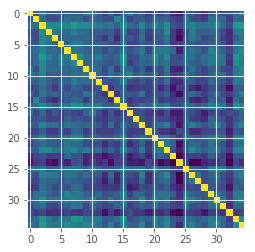

In [62]:
plt.imshow(_df1.values)

In [69]:
marks = ["H3K4me1",
"H3K4me3",
"H3K9me3",
"H3K27me3",
"H3K36me3",
"H3K27ac"
]

merging signal for mark: H3K9me3


/projects/da_workspace/software/miniconda/envs/dlpy3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/projects/da_workspace/software/miniconda/envs/dlpy3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


category track has 27 rows and 35 columns
numeric track has 1 rows and 35 columns


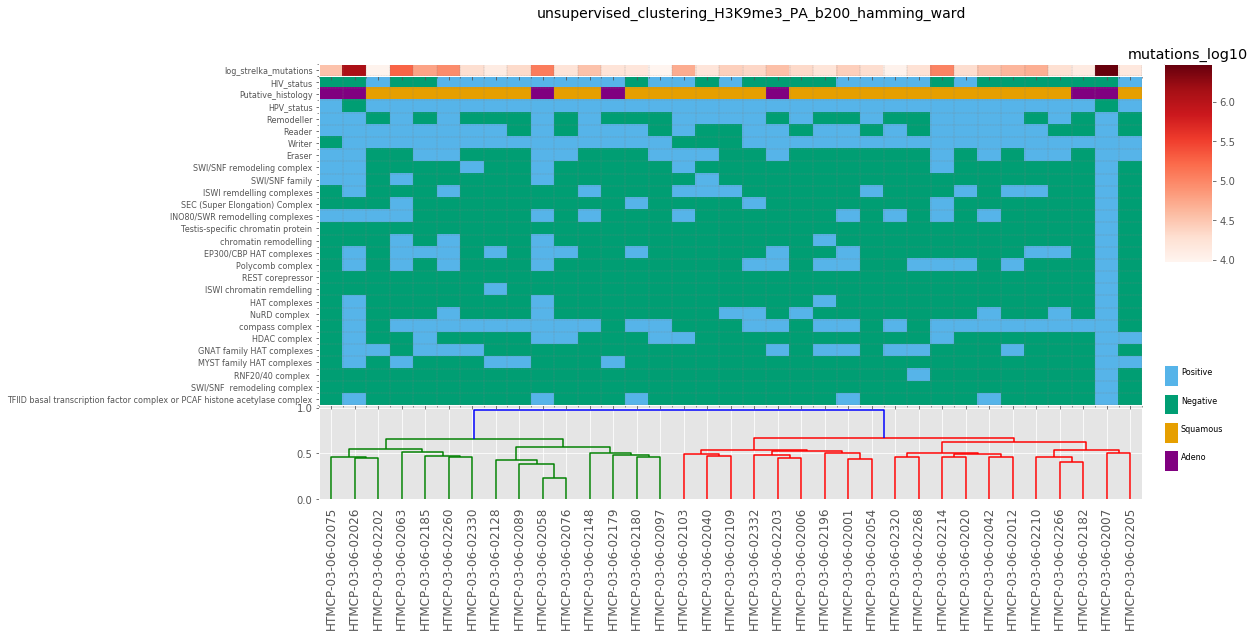

In [104]:
# dists = ['correlation', 'hamming']
dists = ['hamming']
links = [ 'ward' ]
for mark in ['H3K9me3']:#marks:#["H3K4me3"]:#
    print('merging signal for mark: {}'.format(mark))
    f1 = '{0}{1}_matrix.txt'.format(wkdir, mark)
    df1 = pd.read_csv(f1, index_col=['chr', 'ix1', 'ix2'])
    df1['total'] = df1.sum(axis=1)

    # select intervals for clustering
    dfm_mark = df1[(df1.total>15) & (df1.total<19)].drop('total', axis=1)
    
    lib_name = '{} library ID'.format(mark)
    df_meta1 = df_meta[[lib_name, 'patient']].set_index(lib_name)
    d = df_meta1.to_dict()
#     dfm_mark.columns = dfm_mark.columns.to_series().map(d['patient'])
    cat_track = category_track.set_index('patient')
    clrs = ["purple", "#E69F00","#009E73","#56B4E9"]#,"#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
    map_dict1 =  {'Adeno': 0.15,'Squamous': 0.25, 'Negative': 0.35, 'Positive': 0.45}
    ncategory_track, map_dict2 = map_features_to_colors(cat_track, map_dict1, clrs)
    for dist in dists:
        for link in links:
#             print('dist= {0}, link={1}'.format(dist, link))
            plot_cluster(numeric_track, ncategory_track, dfm_mark, mark, map_dict2, dist, link)

In [105]:
dfm_mark.shape

(106805, 35)

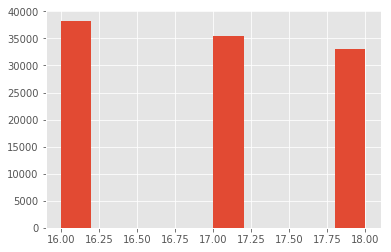

In [106]:
dfm_mark.sum(axis=1).hist()

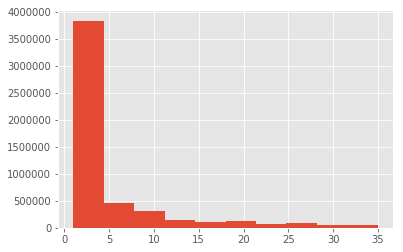

In [79]:
df1.sum(axis=1).hist()

In [78]:
# distribution of patient with signals
df1.sum(axis=1).describe()

count    5.264642e+06
mean     4.884358e+00
std      6.808988e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      5.000000e+00
max      3.500000e+01
dtype: float64

In [82]:
df1['total'] = df1.sum(axis=1)

In [88]:
df1.head()

HTMCP-03-06-02007  HTMCP-03-06-02026  HTMCP-03-06-02063  \
chr ix1   ix2                                                              
1   10000 10200                  1                  1                  1   
    10200 10400                  1                  1                  0   
    39200 39400                  1                  0                  0   
    46800 47000                  1                  1                  0   
    48200 48400                  1                  1                  0   

                 HTMCP-03-06-02214  HTMCP-03-06-02042  HTMCP-03-06-02332  \
chr ix1   ix2                                                              
1   10000 10200                  1                  1                  1   
    10200 10400                  1                  1                  0   
    39200 39400                  0                  0                  0   
    46800 47000                  0                  0                  0   
    48200 48400                  1                  0                  0   

                 HTMCP-03-06-02185  HTMCP-03-06-02012  HTMCP-03-06-02196  \
chr ix1   ix2                                                              
1   10000 10200                  1                  1                  1   
    10200 10400                  1                  1                  1   
    39200 39400                  0                  0                  0   
    46800 47000                  0                  0                  0   
    48200 48400                  1                  0                  1   

                 HTMCP-03-06-02203  ...    HTMCP-03-06-02268  \
chr ix1   ix2                       ...                        
1   10000 10200                  1  ...                    1   
    10200 10400                  0  ...                    0   
    39200 39400                  0  ...                    0   
    46800 47000                  0  ...                    0   
    48200 48400                  0  ...                    0   

                 HTMCP-03-06-02202  HTMCP-03-06-02148  HTMCP-03-06-02103  \
chr ix1   ix2                                                              
1   10000 10200                  1                  1                  1   
    10200 10400                  1                  1                  1   
    39200 39400                  0                  0                  0   
    46800 47000                  1                  0                  0   
    48200 48400                  1                  1                  0   

                 HTMCP-03-06-02089  HTMCP-03-06-02205  HTMCP-03-06-02179  \
chr ix1   ix2                                                              
1   10000 10200                  1                  1                  1   
    10200 10400                  1                  1                  1   
    39200 39400                  0                  0                  0   
    46800 47000                  1                  0                  0   
    48200 48400                  1                  1                  0   

                 HTMCP-03-06-02109  HTMCP-03-06-02076  total  
chr ix1   ix2                                                 
1   10000 10200                  1                  1     35  
    10200 10400                  1                  1     29  
    39200 39400                  0                  0      2  
    46800 47000                  0                  0      5  
    48200 48400                  0                  0     14  

[5 rows x 36 columns]

In [91]:
df1.shape

(5264642, 36)

In [90]:
df1[(df1.total>1) & (df1.total<35)].shape

(3064803, 36)

In [89]:
dfm_mark.head(2)

HTMCP-03-06-02007  HTMCP-03-06-02026  HTMCP-03-06-02063  \
chr ix1   ix2                                                              
1   10000 10200                  1                  1                  0   
    13400 13600                  1                  0                  0   

                 HTMCP-03-06-02214  HTMCP-03-06-02042  HTMCP-03-06-02332  \
chr ix1   ix2                                                              
1   10000 10200                  1                  1                  0   
    13400 13600                  0                  0                  1   

                 HTMCP-03-06-02185  HTMCP-03-06-02012  HTMCP-03-06-02196  \
chr ix1   ix2                                                              
1   10000 10200                  1                  1                  1   
    13400 13600                  0                  0                  1   

                 HTMCP-03-06-02203        ...          HTMCP-03-06-02097  \
chr ix1   ix2                             ...                              
1   10000 10200                  0        ...                          1   
    13400 13600                  1        ...                          0   

                 HTMCP-03-06-02268  HTMCP-03-06-02202  HTMCP-03-06-02148  \
chr ix1   ix2                                                              
1   10000 10200                  0                  1                  1   
    13400 13600                  1                  0                  1   

                 HTMCP-03-06-02103  HTMCP-03-06-02089  HTMCP-03-06-02205  \
chr ix1   ix2                                                              
1   10000 10200                  1                  1                  1   
    13400 13600                  1                  1                  0   

                 HTMCP-03-06-02179  HTMCP-03-06-02109  HTMCP-03-06-02076  
chr ix1   ix2                                                             
1   10000 10200                  1                  0                  1  
    13400 13600                  1                  0                  0  

[2 rows x 35 columns]

den_labels are ['HTMCP-03-06-02148', 'HTMCP-03-06-02266', 'HTMCP-03-06-02332', 'HTMCP-03-06-02054', 'HTMCP-03-06-02196', 'HTMCP-03-06-02006', 'HTMCP-03-06-02012', 'HTMCP-03-06-02109', 'HTMCP-03-06-02001', 'HTMCP-03-06-02128', 'HTMCP-03-06-02210', 'HTMCP-03-06-02026', 'HTMCP-03-06-02040', 'HTMCP-03-06-02179', 'HTMCP-03-06-02007', 'HTMCP-03-06-02180', 'HTMCP-03-06-02182', 'HTMCP-03-06-02075', 'HTMCP-03-06-02203', 'HTMCP-03-06-02063', 'HTMCP-03-06-02076', 'HTMCP-03-06-02202', 'HTMCP-03-06-02042', 'HTMCP-03-06-02214', 'HTMCP-03-06-02020', 'HTMCP-03-06-02268', 'HTMCP-03-06-02330', 'HTMCP-03-06-02320', 'HTMCP-03-06-02185', 'HTMCP-03-06-02103', 'HTMCP-03-06-02058', 'HTMCP-03-06-02205', 'HTMCP-03-06-02260', 'HTMCP-03-06-02097', 'HTMCP-03-06-02089']
adf is:              patient
0  HTMCP-03-06-02148
1  HTMCP-03-06-02266


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


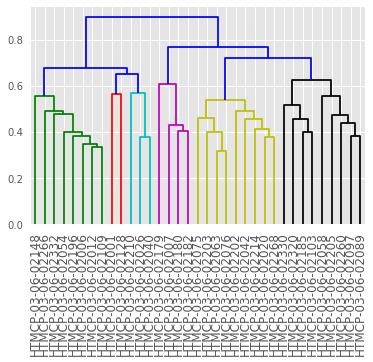

In [84]:
matrix = dfm_mark.values.T
dist='correlation'
link='ward'
Z = linkage(pdist(matrix, dist), link)
aa = dendrogram(Z, leaf_rotation=90.,labels = df1.columns,leaf_font_size=12.,show_contracted=True)#

den_labels = aa['ivl']
print('den_labels are {}'.format(den_labels))
adf = pd.DataFrame(den_labels)
adf.columns = ['patient']
print('adf is: {}'.format(adf.head(2)))

# cluster based on binary result present/absent does not look good, decided to try to use the intervals to cluster on intensity

In [112]:
wkdir

'/projects/da_workspace/software/ChromHMM/Cervical/'

In [121]:
pwd

'/projects/trans_scratch/validations/workspace/szong/Cervical/notebook'

In [130]:
%%bash
cd /projects/da_workspace/software/ChromHMM/Cervical/
# merge intervals for H3K9me3_matrix.txt
awk -F "," '{print $1"\t"$2"\t"$3}' H3K4me3_matrix.txt|tail --lines=+2|sed 's/X/23/g'|sort -k1n -k2n -k3n  > H3K4me3.intervals.txt
# /home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools merge -i /projects/da_workspace/software/ChromHMM/Cervical/H3K4me3_matrix.txt.tmp > H3K4me3.intervals.txt

In [125]:
# look at merged interval length distribution
f = '{}H3K4me3.intervals.txt'.format(wkdir)
dff1 = pd.read_csv(f, sep='\t', header=None)
dff1['len'] = dff1[2] - dff1[1]
dff1.head(2)

/projects/da_workspace/software/miniconda/envs/dlpy3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,len
0,X,61600,61800,200
1,X,62200,63400,1200


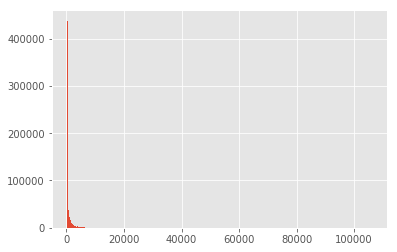

In [128]:
dff1.len.hist(bins=500)

In [133]:
# maybe merge does not really help

In [150]:
marks = ["H3K4me1", "H3K4me3", "H3K9me3", "H3K27me3", "H3K36me3", "H3K27ac"]
dirbase = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/'

In [151]:
for mark in  marks:
    mdir = '{0}{1}_pileup_files'.format(dirbase, mark)
    if not os.path.exists(mdir):
        os.makedirs(mdir)

In [132]:
%%bash
# run this on gphost because the chr string, both file need to match, either both with or without chr string
# cd /projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/H3K9me3_pileup_files
# while read i;do /home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools intersect -a H3K4me3.intervals.txt.sorted -b /projects/seqdev/DA-77/new_pipeline_treatment/step2/$i -wa -wb > $i.intersected;done < H3K9me3_pileup_files.txt

Process is terminated.


In [135]:
# now integrate and calculate the average mark signal
def get_files(f):
    # f = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/sorted_UCSC_A84611_H3K4me3_treat_pileup.bdg.intersected'
    df = pd.read_csv(f,header=None)
    df.columns = ['file']
    df.head(2)
    return df



In [144]:
def integrate_signals(f):
#     f = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/pileup_files/sorted_UCSC_A84611_H3K4me3_treat_pileup.bdg.intersected'
    df = pd.read_csv(f, sep='\t', header=None)
    df.columns = ['chr', 'start', 'end', 'chip_chr', 'chip_start', 'chip_end', 'peak_height']
    df['area'] = df.peak_height * (df.chip_end - df.chip_start)
    dfg = df.groupby(['chr', 'start', 'end'])['area'].sum().reset_index()
    of = '{0}.{1}'.format(f, 'sum')
    dfg.to_csv(of, index=False)

In [146]:
def process_signals(df):
#     f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/treat_pileup_files.txt' 
    for idx, f in df.iterrows():
        f = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/H3K9me3_pileup_files/{}'.format(f['file'])
        integrate_signals(f)
        
        

In [137]:
f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/H3K9me3_pileup_files/H3K9me3_treat_pileup.bdg.intersected.files.txt'
df1 = get_files(f1)
df1.head(2)

,file
0,sorted_UCSC_A84612_H3K9me3_treat_pileup.bdg.in...
1,sorted_UCSC_A84619_H3K9me3_treat_pileup.bdg.in...


In [147]:
process_signals(df1)

In [156]:
def merge_data(df):
    '''merge mark area from all patients'''
    dfm = pd.DataFrame()
    for idx, f in df.iterrows():
        f1 = '{0}/{1}/{2}.sum'.format(dirbase, 'H3K9me3_pileup_files', f['file'])
#         library = '_'.join(f['file_y'].split('_')[2:5])
        library = f['file'].split('_')[2]
        df1 = pd.read_csv(f1).set_index(['chr', 'start', 'end'])
        df1.columns = [library]
        if dfm.empty:
            dfm = df1.copy()
        else:
            dfm = pd.merge(dfm, df1, left_index=True, right_index=True)
    return dfm

In [158]:
dfm = merge_data(df1)

In [159]:
dfm.shape

(2776630, 35)

In [160]:
dfm.head(2)

A84612  A84619  A84626   A84633  A84640  A84647  A84654  \
chr  start end                                                              
chr1 10000 10200  5180.0  4943.0  5213.0  13031.0  5057.0  1483.0  3755.0   
     10200 10400  5398.0  4698.0  4530.0  12601.0  4330.0  1279.0  5220.0   

                  A84661  A84668  A84675   ...    A84787  A84794      A84801  \
chr  start end                             ...                                 
chr1 10000 10200  6689.0  8638.0  2909.0   ...    6457.0  6316.0  4624.89549   
     10200 10400  7362.0  9289.0  2135.0   ...    7032.0  7552.0  3383.42436   

                   A84808  A84822  A84829  A84836  A84843  A84850  A84857  
chr  start end                                                             
chr1 10000 10200  10586.0  1948.0  6620.0  1237.0  1545.0  1867.0  5736.0  
     10200 10400   8456.0  1524.0  5817.0   195.0   562.0   622.0  4465.0  

[2 rows x 35 columns]

A84612  A84619  A84626  A84633  A84640  A84647  A84654  \
chr  start end                                                             
chr1 10000 10200   25.90  24.715  26.065  65.155  25.285   7.415  18.775   
     10200 10400   26.99  23.490  22.650  63.005  21.650   6.395  26.100   

                  A84661  A84668  A84675    ...      A84794     A84801  \
chr  start end                              ...                          
chr1 10000 10200  33.445  43.190  14.545    ...       31.58  23.124477   
     10200 10400  36.810  46.445  10.675    ...       37.76  16.917122   

                  A84808  A84822  A84829  A84836  A84843  A84850  A84857  \
chr  start end                                                             
chr1 10000 10200   52.93    9.74  33.100   6.185   7.725   9.335  28.680   
     10200 10400   42.28    7.62  29.085   0.975   2.810   3.110  22.325   

                    average  
chr  start end               
chr1 10000 10200  24.182188  
     10200 10400  22.223998  

[2 rows x 36 columns]

A84612  A84619  A84626  A84633  A84640  A84647  A84654  \
chr  start end                                                             
chr1 10000 10200  25.900  24.715  26.065  65.155  25.285   7.415  18.775   
     10200 10400  26.990  23.490  22.650  63.005  21.650   6.395  26.100   
     10400 10600  20.915  11.290   6.485  20.370  10.525   4.780   9.200   
     11600 11800  12.375   5.305   1.475   5.995   3.205   2.140   5.355   
     12000 12200   9.635   1.620   1.175   4.070   3.695   1.530   7.190   

                  A84661  A84668  A84675    ...      A84794     A84801  \
chr  start end                              ...                          
chr1 10000 10200  33.445  43.190  14.545    ...      31.580  23.124477   
     10200 10400  36.810  46.445  10.675    ...      37.760  16.917122   
     10400 10600  10.220  20.340   8.565    ...      19.340   6.951879   
     11600 11800   4.250  14.155   2.455    ...       4.130   4.740318   
     12000 12200   5.675  10.345   2.525    ...       3.355   3.312936   

                  A84808  A84822  A84829  A84836  A84843  A84850  A84857  \
chr  start end                                                             
chr1 10000 10200  52.930   9.740  33.100   6.185   7.725   9.335  28.680   
     10200 10400  42.280   7.620  29.085   0.975   2.810   3.110  22.325   
     10400 10600   8.575   6.110  14.915   2.340   2.200   0.000   7.135   
     11600 11800   6.285   2.130   6.150   1.150   1.400   3.920   7.360   
     12000 12200   3.300   1.515   5.255   1.325   2.990   5.605   7.325   

                    average  
chr  start end               
chr1 10000 10200  24.182188  
     10200 10400  22.223998  
     10400 10600   9.823600  
     11600 11800   5.568313  
     12000 12200   4.849528  

[5 rows x 36 columns]

2.3024313825545035

(181014, 35)

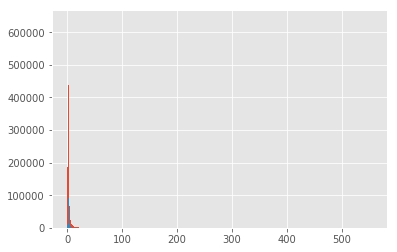

In [277]:




dfm2 = dfm/200
dfm2.head(2)
dfm2['average'] = dfm2.mean(axis=1)
dfm2.head()
dfm2['average'].hist(bins=1000)
ave_up = dfm2['average'].describe(percentiles=[.25, .5, .75, .9999])['75%']

dfm2['std'] = dfm2.std(axis=1)

std_thr = dfm2['std'].describe(percentiles=[.25, .5, .75, .99])['75%']
std_thr
dfm2['std'].hist(bins=1000)

# std_thr = (dfm2['std'].describe())['75%']
ave_low = (dfm2['average'].describe())['25%']

dfm2 = dfm2[(dfm2['std']>std_thr) & (dfm2['average']>ave_low) & (dfm2['average'] < ave_up)].drop('std', axis=1).drop('average', axis=1)

dfm2.shape

In [258]:
# dfm2[dfm2.mean(axis=1)>400].head()
# this shows often heavily marked regions are close to centromere. however centromere regions resist to repressive marks, meaning remain transcriptionally active although heavily marked by repressive marks


# Scale or not scale features
my two cents here:
1. what do the values mean? for example, expression data is RPKM. these are already normalized data, read per kilobase of a million aligned reads. 5 rpkm in lib a can be directly compared to 10 rpkm in lib b. in chipseq analysis, i used the direct pileup file, so they  are not normalized the same way as rpkm. i think i should normalize them to sequence depth(or number of aligned reads), so that the values are comparable among libraries.
2. should i scale the values for each library? column scale, i don't think so.
3. should i scale the values for each feature (feature scaling). for example in expression, gene A may  be highly expressed while gene B are barely expressed. the question is should i treat all genes equally, giving them the same weight. If this is the case, i need to scale the features so that the distances are not just dominated by those highly expressed genes. or to put it another way, to avoid the clustering is driven largely by those highly expressed genes. on the other hand, if we think genes with higher expression should have more weights, we don't need to scale the feature. Another apparent scenario which needs scaling is when the features are on different scale, for example, body weight measured in kg and shoes size measured in centimere. sklearn standardScaler gives the z-score for columns, so that the values are centered at 0 with a unit standard deviation.

http://sebastianraschka.com/Articles/2014_about_feature_scaling.html


https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering
The issue is what represents a good measure of distance between cases.

If you have two features, one where the differences between cases is large and the other small, are you prepared to have the former as almost the only driver of distance?

So for example if you clustered people on their weights in kilograms and heights in metres, is a 1kg difference as significant as a 1m difference in height? Does it matter that you would get different clusterings on weights in kilograms and heights in centimetres? If your answers are "no" and "yes" respectively then you should probably scale.

On the other hand, if you were clustering Canadian cities based on distances east/west and distances north/south then, although there will typically be much bigger differences east/west, you may be happy just to use unscaled distances in either kilometres or miles (though you might want to adjust degrees of longitude and latitude for the curvature of the earth).

In [285]:
# standardscaler scale matrix to column average=0, std=1, this is necessary to avoid large values dominate the distance
dfm2.head(2)

A84612  A84619  A84626  A84633  A84640  A84647  A84654  \
chr  start end                                                             
chr1 13200 13400   1.010   5.000   2.220    1.37   0.000   2.305   0.000   
     13800 14000   1.535   0.635   4.375    1.86   1.385   4.475   0.985   

                  A84661  A84668  A84675   ...    A84787  A84794    A84801  \
chr  start end                             ...                               
chr1 13200 13400   5.845    5.63   2.325   ...     6.575   0.000  2.978118   
     13800 14000   6.230    1.04   2.335   ...     6.120   1.865  0.638798   

                  A84808  A84822  A84829  A84836  A84843  A84850  A84857  
chr  start end                                                            
chr1 13200 13400   2.050   1.100   1.485   1.505   0.495   2.790   2.600  
     13800 14000   3.585   1.405   4.805   3.740   1.280   4.075   2.795  

[2 rows x 35 columns]

In [286]:
dfm2_scaled = pd.DataFrame(StandardScaler().fit_transform(dfm2.T).T)
dfm2_scaled.columns = dfm2.columns
dfm2_scaled.index = dfm2.index

In [291]:
# this shows features are properly scaled with mean=0, and std=1
dfm2_scaled.std(axis=1)
dfm2_scaled.sum(axis=1)

chr   start      end      
chr1  13200      13400        1.014599
      13800      14000        1.014599
      14600      14800        1.014599
      28000      28200        1.014599
      29000      29200        1.014599
      29800      30000        1.014599
      30000      30200        1.014599
      38800      39000        1.014599
      237800     238000       1.014599
      240400     240600       1.014599
      240600     240800       1.014599
      242200     242400       1.014599
      420800     421000       1.014599
      459200     459400       1.014599
      460600     460800       1.014599
      522200     522400       1.014599
      522400     522600       1.014599
      522600     522800       1.014599
      523800     524000       1.014599
      524600     524800       1.014599
      540800     541000       1.014599
      541400     541600       1.014599
      564000     564200       1.014599
      564200     564400       1.014599
      566800     567000       1.01459

chr   start      end      
chr1  13200      13400        6.784287e-15
      13800      14000        9.200973e-15
      14600      14800       -2.220446e-15
      28000      28200       -1.110223e-15
      29000      29200        1.137979e-15
      29800      30000        3.330669e-16
      30000      30200       -2.275957e-15
      38800      39000       -1.221245e-15
      237800     238000       1.443290e-15
      240400     240600       3.941292e-15
      240600     240800       1.110223e-15
      242200     242400       8.331877e-15
      420800     421000       6.106227e-15
      459200     459400       2.775558e-15
      460600     460800      -5.967449e-16
      522200     522400      -4.551914e-15
      522400     522600      -6.071532e-17
      522600     522800       3.511080e-15
      523800     524000       8.604228e-16
      524600     524800      -1.376677e-14
      540800     541000       6.661338e-16
      541400     541600      -1.314227e-14
      564000     564200    

In [296]:
dfm2_scaled.head(2)

A84612    A84619    A84626    A84633    A84640    A84647  \
chr  start end                                                                 
chr1 13200 13400 -0.647444  0.978094 -0.154486 -0.500779 -1.058921 -0.119857   
     13800 14000 -0.553665 -0.873533  0.455696 -0.438157 -0.606977  0.491237   

                    A84654   A84661    A84668    A84675    ...       A84787  \
chr  start end                                             ...                
chr1 13200 13400 -1.058921  1.32235  1.234758 -0.111709    ...     1.619754   
     13800 14000 -0.749140  1.11498 -0.729593 -0.269338    ...     1.075885   

                    A84794    A84801    A84808    A84822    A84829    A84836  \
chr  start end                                                                 
chr1 13200 13400 -1.058921  0.154373 -0.223745 -0.610778 -0.453928 -0.445780   
     13800 14000 -0.436380 -0.872184  0.174923 -0.599869  0.608522  0.230012   

                    A84843    A84850    A84857  
chr  start end                                  
chr1 13200 13400 -0.857257  0.077733  0.000327  
     13800 14000 -0.644295  0.349074 -0.105850  

[2 rows x 35 columns]

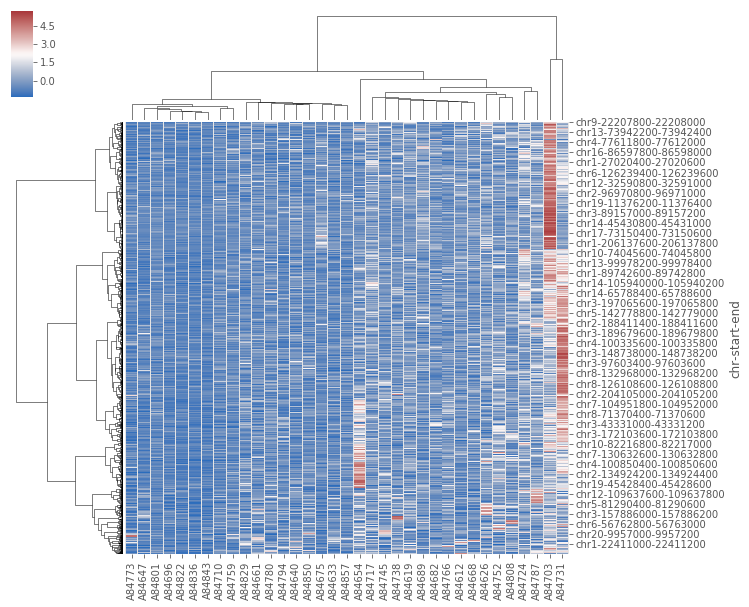

In [297]:
cmap = sns.light_palette('red', as_cmap=True)
g = sns.clustermap(dfm2_scaled, cmap="vlag", method='ward', metric='euclidean', z_score=None)
_ = plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
pass